In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from spiceracs.utils import *
import numpy as np
import multiprocessing as mp
from spectral_cube import SpectralCube
from tqdm import tqdm, trange, tnrange, tqdm_notebook
from astropy.io import fits

In [2]:
hi4pi = SpectralCube.read('/home/athomson/gasalec/HI4PI/HI4PI_CAR_parkes.fits')

In [3]:
hi4pi

SpectralCube with shape=(945, 720, 1440) and unit=K:
 n_x:   1440  type_x: GLON-CAR  unit_x: deg    range:   179.875000 deg:  180.125000 deg
 n_y:    720  type_y: GLAT-CAR  unit_y: deg    range:   -89.875000 deg:   89.875000 deg
 n_s:    945  type_s: VRAD      unit_s: m / s  range:  -606648.293 m / s:  609426.638 m / s

In [4]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [237]:
def moment(arr, data, start, stop):
    mom0 = np.nansum(data, axis=0)
    arr[start:stop,:] = mom0

In [238]:
import ctypes as c

In [239]:
n, m = hi4pi.shape[1], hi4pi.shape[2]
mp_arr = mp.Array(c.c_double, n*m) # shared, can be used from multiple processes
# then in each new process create a new numpy array using:
buff_arr = np.frombuffer(mp_arr.get_obj()) # mp_arr and arr share the same memory
# make it two-dimensional
arr = buff_arr.reshape((n,m)) # b and arr share the same memory
arr[:] = np.zeros((n,m))*np.nan

In [240]:
def cpu_to_use(max_cpu, count):
    factors = []
    for i in range(1, count + 1):
        if count % i == 0:
            factors.append(i)
    factors = np.array(factors)
    return max(factors[factors <= max_cpu])

In [241]:
procs = []
n = hi4pi.shape[1]
ncpus = cpu_to_use(28, n)
width = n//ncpus
#width = 2
for i in range(ncpus):
    start = i*width
    stop = start+width
    proc = mp.Process(target=moment, args=(arr, hi4pi[:,start:stop,:], start, stop))
    procs.append(proc)


In [242]:
for p in procs:
    p.start()
for p in procs:
    p.join()


In [229]:
for p in procs:
    p.close()

ValueError: Cannot close a process while it is still running. You should first call join() or terminate().

<IPython.core.display.Javascript object>


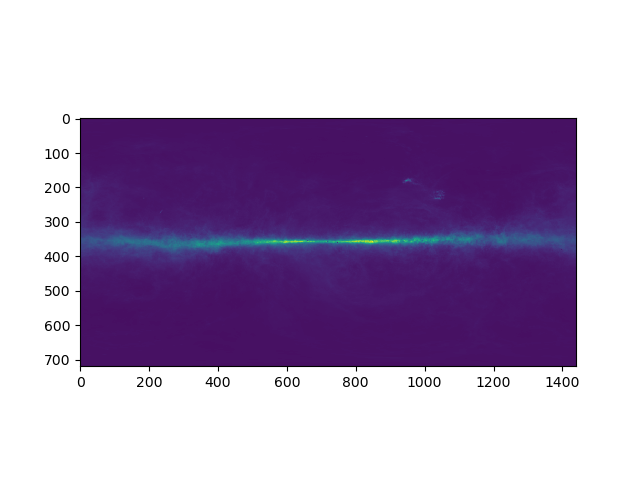

In [243]:
plt.figure()
plt.imshow(arr)

In [24]:
import time

In [26]:
def doubler(number):
    """
    A doubling function that can be used by a process
    """
    result = number * 2
    time.sleep(10)
    proc = os.getpid()
    print('{0} doubled to {1} by process id: {2}'.format(
        number, result, proc))
    
if __name__ == '__main__':
    numbers = [5, 10, 15, 20, 25]
    procs = []

for index, number in enumerate(numbers):
    proc = mp.Process(target=doubler, args=(number,))
    procs.append(proc)
    proc.start()

for proc in procs:
    proc.join()

5 doubled to 10 by process id: 9661
10 doubled to 20 by process id: 9662
15 doubled to 30 by process id: 9663
20 doubled to 40 by process id: 9664
25 doubled to 50 by process id: 9665


In [6]:
def do_work(arr, start, width, data):
    mom0 = np.nansum(data[:,i*width:i*width+width,:], axis=0)
    arr[start:start+width] = mom0

def split_work(num):
    n, m, l = hi4pi.shape[0], hi4pi.shape[1], hi4pi.shape[2]
    width  = m//num
    mp_arr = mp.Array(c.c_double, m*l) # shared, can be used from multiple processes
    # then in each new process create a new numpy array using:
    arr = np.frombuffer(mp_arr.get_obj()) # mp_arr and arr share the same memory
    # make it two-dimensional
    shared = arr.reshape((m,l)) # b and arr share the same memory
    
    mp_arr = mp.Array(c.c_double, n*m) # shared, can be used from multiple processes
    # then in each new process create a new numpy array using:
    arr = np.frombuffer(mp_arr.get_obj()) # mp_arr and arr share the same memory
    # make it two-dimensional
    data = arr.reshape((n,m)) # b and arr share the same memory
    data[:] = hi4pi[:] 
    #shared = mp.Array('f',n)
    #shared[:] = hi4pi.hdu.data
    
    print("values are %s" % shared[:])

    processes = [mp.Process(
            target=do_work, 
            args=(shared, i*width, width, data)
        ) for i in range(num)]
    for p in processes:
        p.start()
    for p in processes:
        p.join()

    print("values are %s" % shared[:])
    print("type is %s" % type(shared[0]))

if __name__ == '__main__':
    split_work(4)

KeyboardInterrupt: 

In [ ]:
def do_work(data, start, width):
    data[start:start+width] = np.array(data[start:start+width])**2
    time.sleep(2)

def split_work(num):
    n = 20
    width  = n//num
    shared = mp.Array('f',n)
    shared[:] = np.arange(0, n, 1)
    print("values are %s" % shared[:])

    processes = [mp.Process(target=do_work, args=(shared, i*width, width)) for i in range(num)]
    for p in processes:
        p.start()
    for p in processes:
        p.join()

    print("values are %s" % shared[:])
    print("type is %s" % type(shared[0]))

if __name__ == '__main__':
    split_work(4)